In [13]:
from qiskit import transpile, QuantumCircuit, IBMQ
from itertools import combinations
from tools.noise_tools import get_noise_model
from qiskit.visualization import plot_histogram
from numpy import pi, linspace
from qiskit.providers.aer import QasmSimulator

if not IBMQ.active_account():
    if not IBMQ.stored_account():
        with open('Token') as file:
            token = file.readline()

        IBMQ.save_account(token)

    IBMQ.load_account()

name = 'ibm_oslo'
provider = IBMQ.get_provider(hub = 'ibm-q', group = 'open', project = 'main')
device_backend = provider.get_backend(name)

'\ndef circuit_measure(spins: int, time: float, trotter_steps: int, coupling: float):\n    circuit = QuantumCircuit(spins, spins)\n    trotter_circuit = trotter_circuit(spins, time, trotter_steps, coupling)\n'

In [22]:
spins = 4
quantum_times = linspace(0, 2 * pi, 50)
shots = 5000
backend = QasmSimulator()
noise = get_noise_model(.990e-2, 2e-3, 5.910e-3, 161.48e-6, 57.34e-6, 4, 337e-9)
noisy_backend = QasmSimulator(noise_model = noise)

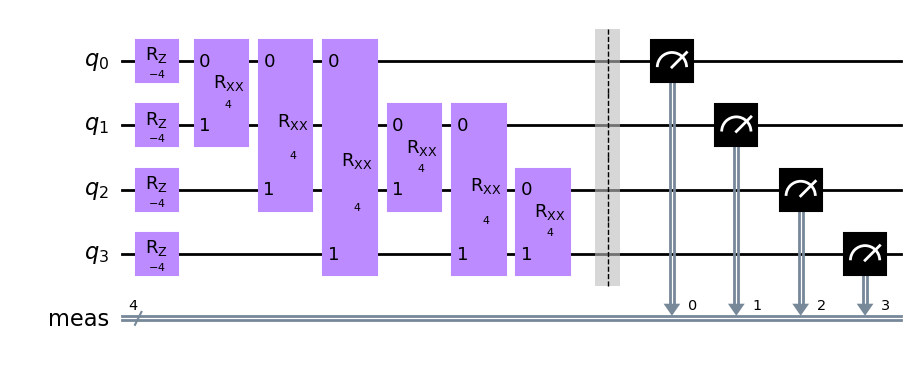

In [29]:
circuit = trotter_circuit(spins, 4, 1, 1)
circuit.measure_all()
circuit.draw('mpl')
#circuit = transpile(circuit, device_backend)
#circuit.draw('mpl')

In [27]:
job = noisy_backend.run(circuit, shots = shots)
result = job.result()
counts = result.get_counts()

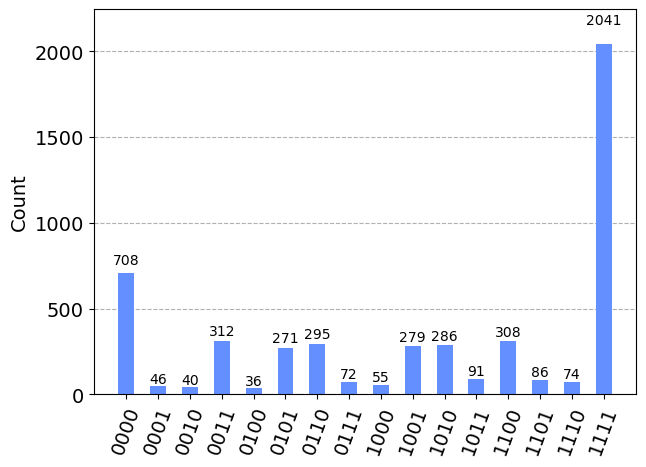

In [28]:
plot_histogram(counts)

##  Digital Quantum Simulations of Time Evolution - Simulating the Dicke Model
---
## Introduction
A Quantum Battery (QB) can be defined as a $d$-dimensional quantum systems with non-degenerate energy levels from which work can be reversibly extracted – and on which energy can be reversibly deposited – by means of cyclic unitary operations.

## Cavity Assisted Charging
One can use a [Dicke model](https://en.wikipedia.org/wiki/Dicke_model) to powerfully charge an array of 2-level systems (TLSs) coupled with a quantized single-mode electro-magnetic field. The model considered in such a case is given by the time-dependent Dicke Hamiltonian

$$
H^{(n)}=\hbar\omega_c a^\dagger a +\omega_aS_z+2\omega_c\lambda_tS_x(a+a^\dagger)
$$

where, in particular

$$
S_i=\frac{\hbar}{2}\sum_{l=1}^n\sigma_i^{(l)}
$$
 
are the components of the collective spin operators expressed in terms of Pauli operators $\sigma_i^{(l)}$ of the $l$-th TLS.

## The model we use
We study the following Hamiltonian

$$
H = \omega_z S_z - g S^2_x=H_0+H_1
$$

that can be obtained from the Dicke model 

In [6]:
# Ignore: things to make plots pretty on my computer 
from pkg_resources import working_set

if 'jupyterthemes' in ["%s" % package.key for package in working_set]:
    from jupyterthemes import jtplot
    jtplot.style(theme = 'monokai', context = 'notebook', ticks = True, grid = True)

In [7]:
from tools.quantum_tools import quantum_simulator, probability_and_internal_energy, measure_coupling_energy
from tools.classical_tools import classical_simulator
from tools.noise_tools import get_noise_model

In [8]:
from matplotlib.pyplot import plot, xlabel, ylabel, title, show, legend, ylim, text
from numpy import linspace, pi, zeros_like, zeros, divide, array, arange, flipud, sqrt
from seaborn import heatmap
from qiskit.providers.aer import QasmSimulator
from qiskit import IBMQ
from qiskit.visualization import plot_gate_map, plot_histogram

## Probability of all spins up and energy variation
---
### Classical simulation

Here we perform the time evolution from the spin down state using a classical simulation, thus, practically, products between matrices. We will compare the results obtained here with the ones that we will get in the quantum simulation. In particular we:

 - study the evolution of the probability of having all spin up.
 - evaluate average energy of first $H$ contribution (total magnetization time variation), that is $E_i(t)\equiv\text{tr}[\rho(t)H_i]-\text{tr}[\rho(0)H_i]$ with $i=0$ and also evaluate the coupling energy (obtained cosnidering $i=1$)

In [9]:
maximal_time = 2 * pi  # Maximal time of the simulation
spins = 3 # Number of 2-level systems
coupling = 1e-3 # Coupling parameter
frequency = 1

In [10]:
%%time
times = linspace(0, maximal_time, 500) # Time discretization
probabilities, internal, interaction = classical_simulator(times, spins, frequency, coupling)

CPU times: user 91.3 ms, sys: 14.7 ms, total: 106 ms
Wall time: 100 ms


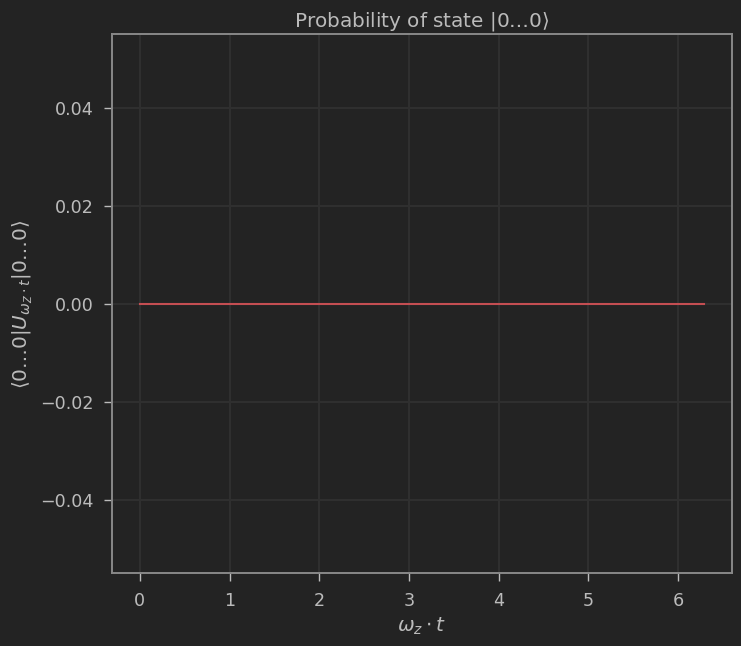

In [11]:
plot(times, probabilities, '-r')
xlabel(r'$\omega_z \cdot t$')
ylabel(r'$\langle 0\dots 0|U_{\omega_Z\cdot t}|0\dots0\rangle$')
title(r'Probability of state $|0\dots0\rangle$')
show()

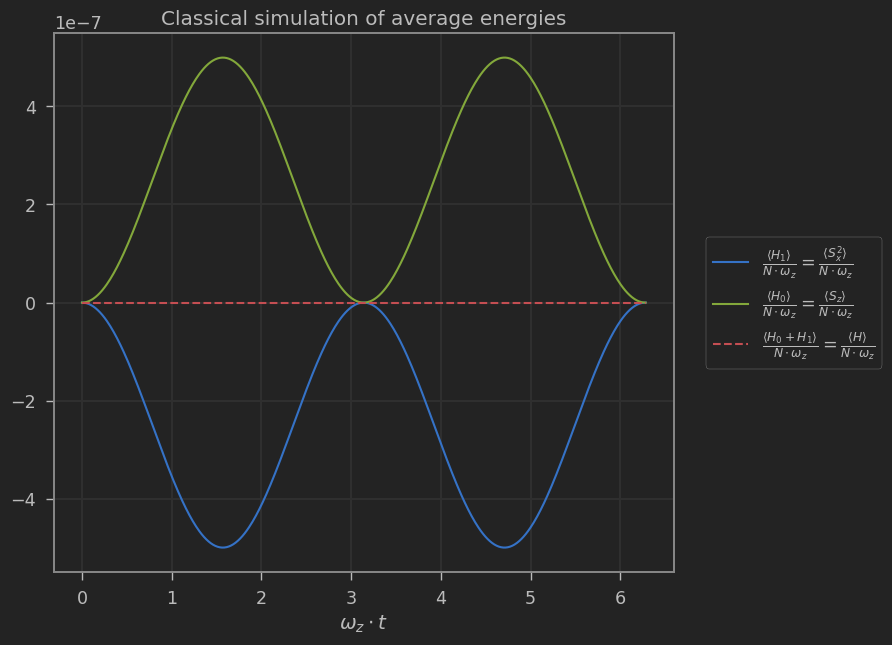

In [12]:
plot(times, interaction, label = r'$\frac{\langle H_1\rangle}{N\cdot\omega_z}=\frac{\langle S_x^2\rangle}{N\cdot\omega_z} $' )    
plot(times, internal, label = r'$\frac{\langle H_0\rangle}{N\cdot\omega_z}=\frac{\langle S_z\rangle}{N\cdot\omega_z} $' )  
plot(times, internal + interaction, '--', label = r'$\frac{\langle H_0 + H_1\rangle}{N\cdot\omega_z}=\frac{\langle H\rangle}{N\cdot\omega_z} $' )  
legend(loc = 'center right', bbox_to_anchor = (1.35, 0.5))
title(r'Classical simulation of average energies')
xlabel(r'$\omega_z \cdot t$')
show()

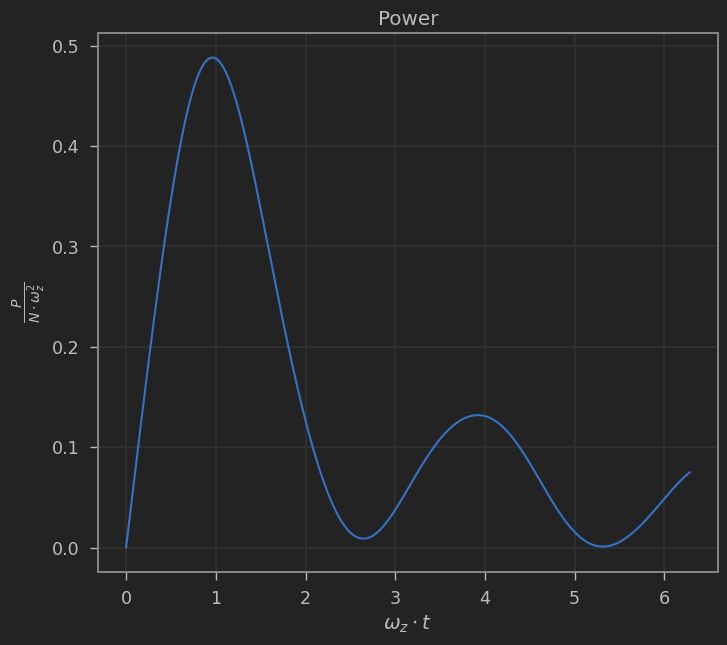

In [8]:
plot(times, divide(internal, times, out = zeros_like(internal), where = times != 0))
title(r'Power')
ylabel(r'$\frac{P}{N\cdot\omega_z^2}$')
xlabel(r'$\omega_z \cdot t$')
show()

Now we study the cases $gN < 1$ and $gN >1$ (rescale for $\omega_z$). We note that the effective coupling $G=gN$ is the transition phase parameter and we should observe *universal curves* varying it.

In [9]:
'''
%%time
maximum_spins = 7
t = linspace(0, 2 * pi, 50)
couplings = arange(0.1, 1.5, 0.1).round(decimals = 2)
maximum_power = array([zeros_like(couplings) for _ in range(maximum_spins - 1)])

for j, g in enumerate(couplings):
    for i in range(2, maximum_spins + 1):
        _, energy, _ = classical_simulator(t, i, frequency, g)
        power = divide(energy, t, out = zeros_like(energy), where = t != 0)
        maximum_power[1 - i][j] = power.max()

figure = heatmap(maximum_power, xticklabels = couplings, yticklabels = [i for i in range(maximum_spins, 1, -1)])
title('Maximal power')
xlabel(r'$g$')
ylabel(r'$N$')
text(16.5, 0.0, r'$\frac{P_{max}}{N\cdot\omega_z^2}$', horizontalalignment = 'center', verticalalignment = 'center')
show()
'''

"\n%%time\nmaximum_spins = 7\nt = linspace(0, 2 * pi, 50)\ncouplings = arange(0.1, 1.5, 0.1).round(decimals = 2)\nmaximum_power = array([zeros_like(couplings) for _ in range(maximum_spins - 1)])\n\nfor j, g in enumerate(couplings):\n    for i in range(2, maximum_spins + 1):\n        _, energy, _ = classical_simulator(t, i, frequency, g)\n        power = divide(energy, t, out = zeros_like(energy), where = t != 0)\n        maximum_power[1 - i][j] = power.max()\n\nfigure = heatmap(maximum_power, xticklabels = couplings, yticklabels = [i for i in range(maximum_spins, 1, -1)])\ntitle('Maximal power')\nxlabel(r'$g$')\nylabel(r'$N$')\ntext(16.5, 0.0, r'$\x0crac{P_{max}}{N\\cdot\\omega_z^2}$', horizontalalignment = 'center', verticalalignment = 'center')\nshow()\n"

### Noiseless quantum simulation
Herw we perform the time evolution from the spin down state, implementing trotterization. In this section we perform an ideal quantum simulation without any noise and compare the results with the one obtained with the classical simulation.

In [10]:
# Initialization
quantum_times = linspace(0, maximal_time, 50)
shots = 3000
backend = QasmSimulator()
trotter_steps = 10

In [11]:
quantum_probabilities, quantum_internal, quantum_interaction = \
quantum_simulator(quantum_times, spins, trotter_steps, frequency, coupling, backend, shots)

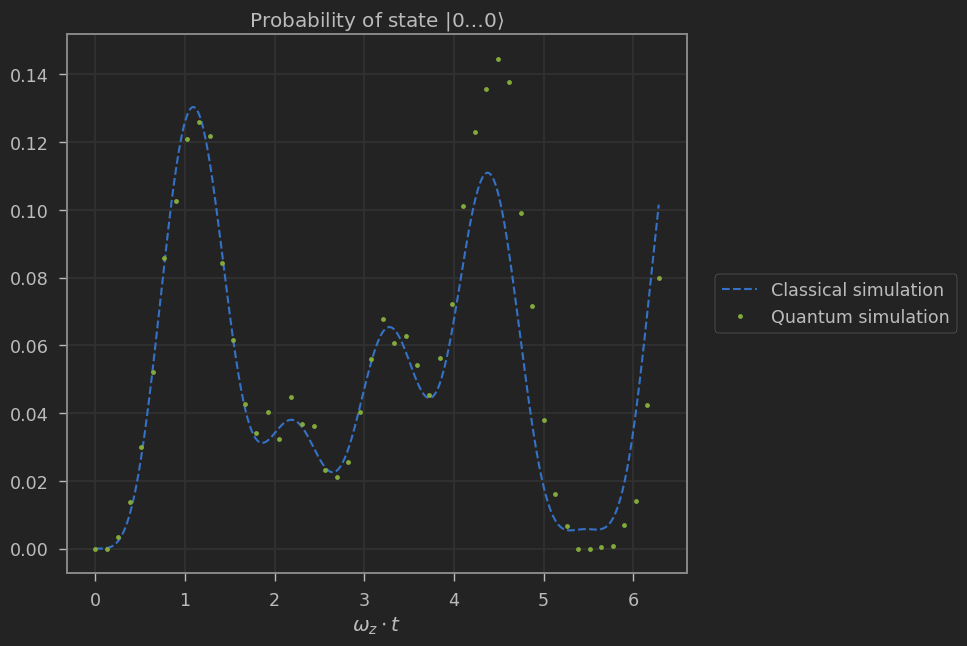

In [12]:
# Plotting
plot(times, probabilities, '--', label = "Classical simulation")
plot(quantum_times, quantum_probabilities, '.', label = "Quantum simulation")
xlabel(r'$\omega_z \cdot t$')
title(r'Probability of state $|0\dots0\rangle$')
legend(loc = 'center right', bbox_to_anchor = (1.45, 0.5))
show()

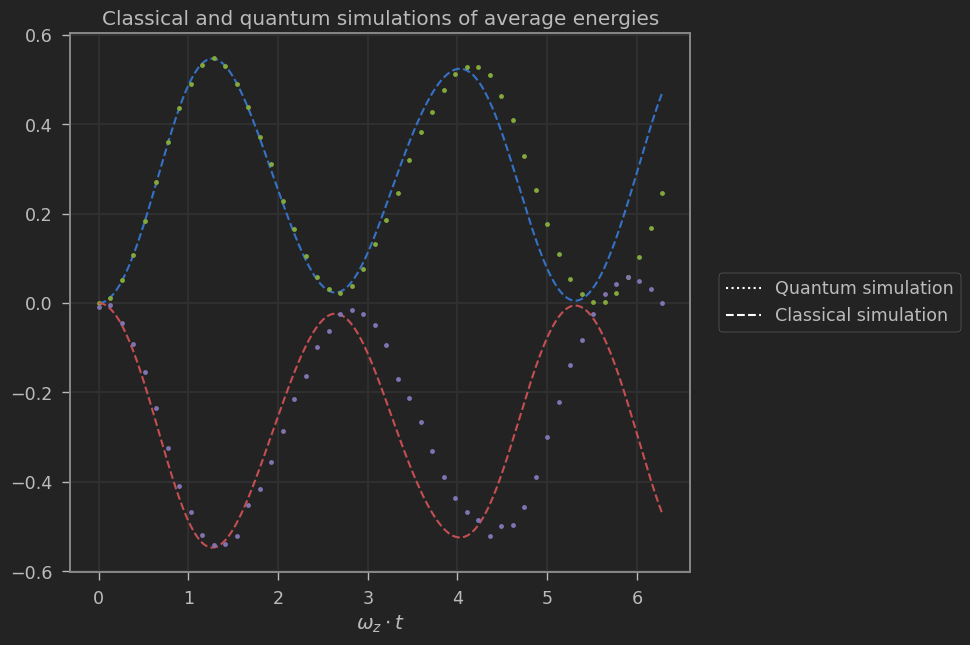

In [13]:
compare_energies(times, quantum_times, internal, quantum_internal, \
                 interaction, quantum_interaction)

## Noisy quantum simulation
Here we perform a quantum simulation applying a noise model.

 - `(1.990e-2, 0, 0, 1, 1, spins, 337e-9)`, quando c'è solo solo il *readout error* il rumore non inficia i risultati (già corretti)
 - `(0, dep, 0, 1, 1, spins, 337e-9)`

In [14]:
dep = 2e-3
'''
for i in range(spins):
    dep += device_backend.properties().gate_error('x', i) 
    
dep /= spins
print(dep)
'''
# errors = [1.990e-2, dep, 5.910e-3, 161.48e-6, 57.34e-6]
noise = get_noise_model(.990e-2, 2e-3, 5.910e-3, 161.48e-6, 57.34e-6, spins, 337e-9)
backend = QasmSimulator(noise_model = noise)

In [15]:
_, noisy_internal, noisy_interaction = \
quantum_simulator(quantum_times, spins, trotter_steps, frequency, coupling, backend, shots)

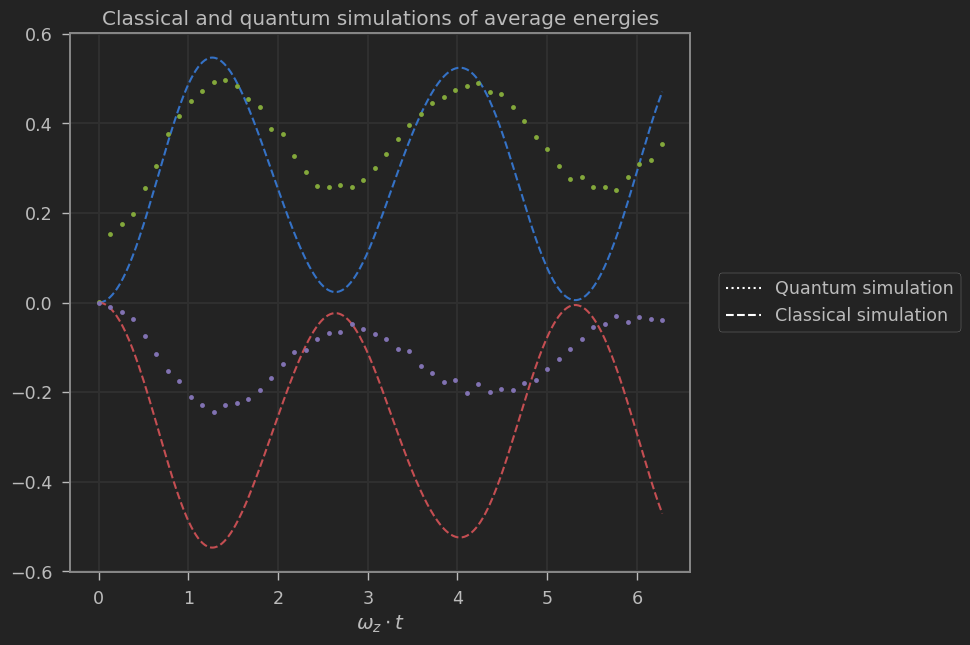

In [16]:
compare_energies(times, quantum_times, internal, noisy_internal, \
                 interaction, noisy_interaction)

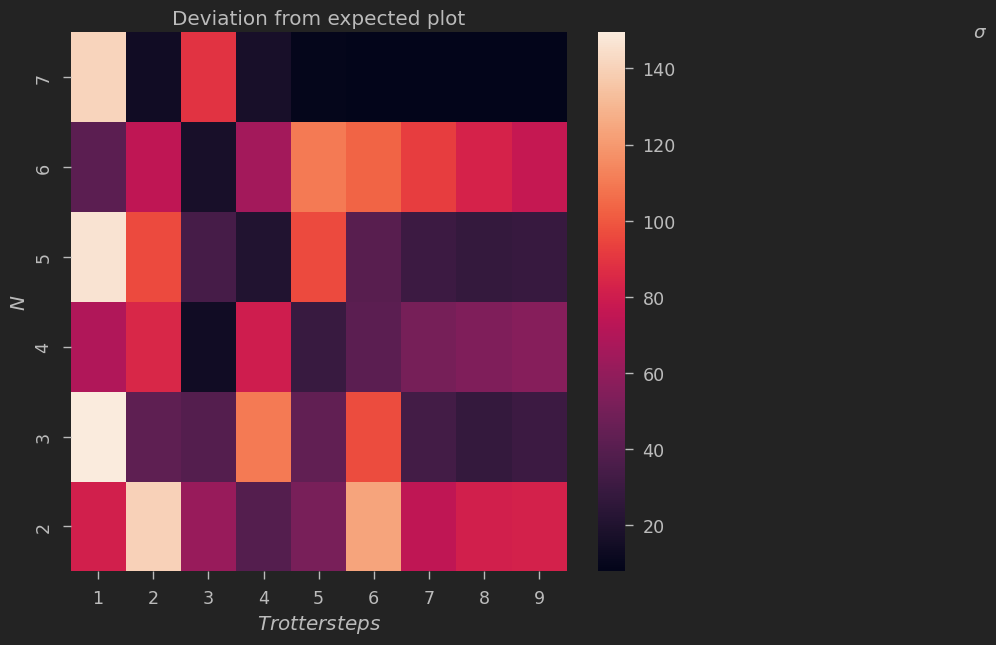

CPU times: user 5min 33s, sys: 1min 15s, total: 6min 48s
Wall time: 9min 8s


In [22]:
%%time
maximum_spins = 7
t = linspace(0, 2 * pi, 50)
trotterStep = arange(1, 10)
deviaz = array([zeros_like(trotterStep) for _ in range(maximum_spins - 1)], dtype = float)
_, Ideal, _ = classical_simulator(t, spins, frequency, coupling)

for j, step in enumerate(trotterStep):
    for i in range(2, maximum_spins + 1):
        _, Noisy, _ = quantum_simulator(t, i, step, frequency, coupling, backend, shots)
        deviaz[i - 2][j] = divide(((Noisy - Ideal) ** 2), Ideal, out = zeros_like(((Noisy - Ideal) ** 2)), where = t != 0).sum()
        #print(Noisy)
        #print(sqrt(((Noisy - Ideal) ** 2).sum()))
        #print(deviaz[i - 2][j])

figure = heatmap(deviaz, xticklabels = trotterStep, yticklabels = [i for i in range(maximum_spins, 1, -1)])
title('Deviation from expected plot')
xlabel(r'$Trotter steps$')
ylabel(r'$N$')
text(16.5, 0.0, r'$\sigma$', horizontalalignment = 'center', verticalalignment = 'center')
show()

Now we try to try to apply some error mitigation.

In [17]:
_, mitigated_internal, mitigated_interaction = \
quantum_simulator(quantum_times, spins, trotter_steps, frequency, coupling, backend, shots, True)

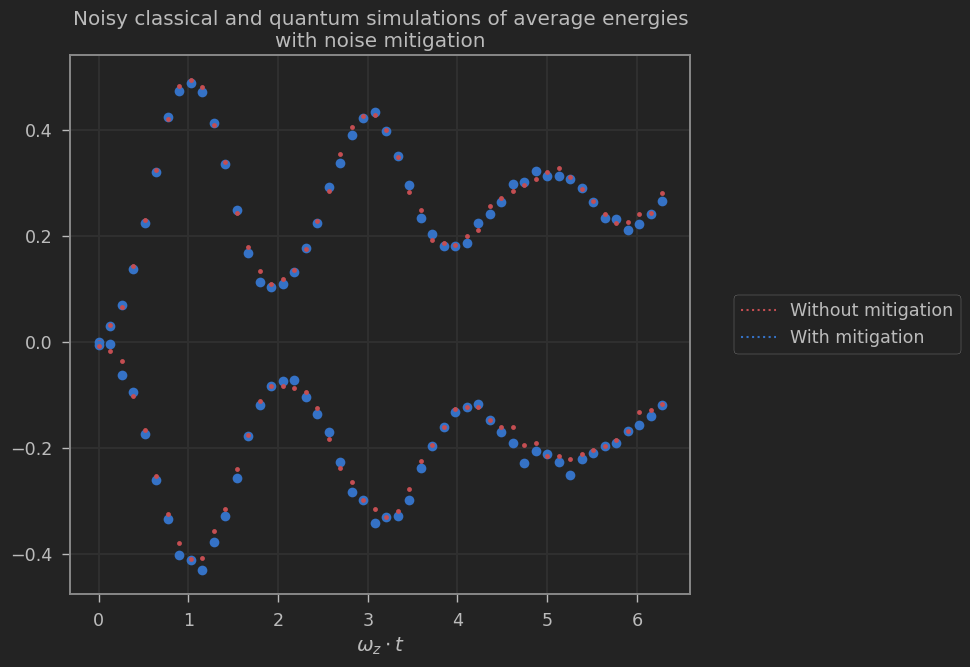

In [18]:
from matplotlib.lines import Line2D
plot(quantum_times, mitigated_internal, 'bo')
plot(quantum_times, noisy_internal, 'r.')
plot(quantum_times, mitigated_interaction, 'bo')
plot(quantum_times, noisy_interaction, 'r.')
colors = ['r', 'b']
lines = [Line2D([0], [0], color = c, linestyle = ':') for c in colors]
labels = ['Without mitigation', 'With mitigation']
legend(lines, labels, loc = 'center right', bbox_to_anchor = (1.45, 0.5))
title('Noisy classical and quantum simulations of average energies\nwith noise mitigation')
xlabel(r'$\omega_z \cdot t$')
show()

 ### Simulation on real device
 Here we simulate the evolution running the circuit on a real device.

In [19]:
if not IBMQ.active_account():
    if not IBMQ.stored_account():
        with open('Token') as file:
            token = file.readline()

        IBMQ.save_account(token)

    IBMQ.load_account()

backends = IBMQ.providers()[0].backends()

for i, x in enumerate(backends):
    print((i, x.name()))

(0, 'ibmq_qasm_simulator')
(1, 'ibmq_lima')
(2, 'ibmq_belem')
(3, 'ibmq_quito')
(4, 'simulator_statevector')
(5, 'simulator_mps')
(6, 'simulator_extended_stabilizer')
(7, 'simulator_stabilizer')
(8, 'ibmq_manila')
(9, 'ibm_nairobi')
(10, 'ibm_oslo')


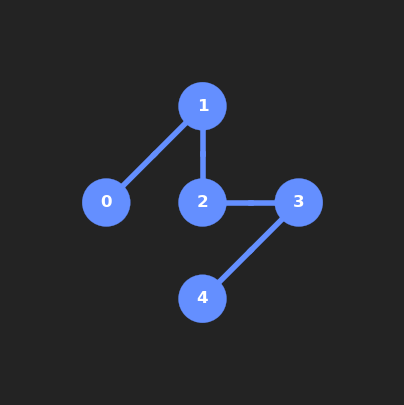

In [20]:
info = backends[-3]
provider = IBMQ.get_provider(hub = info.hub, group = info.group, project = info.project)
device_backend = provider.get_backend(info.name())
display(plot_gate_map(device_backend)) # To visualize the backend hardware map

In [21]:
# Counting
'''
device_probabilities, device_internal_energy, device_coupling_energy = \
quantum_simulator(quantum_times, spins, trotter_steps, frequency, coupling, device_backend, shots)
'''
job = device_backend.retrieve_job('63caec4f4366175cf2ce7b4e')
# Getting the results
result = job.result()
counts = result.get_counts()
half = len(quantum_times)
first_counts = counts[:half]
second_counts = counts[half:]

# Extracting the wanted information from the data
device_probabilities, device_internal = \
probability_and_internal_energy(quantum_times, first_counts, spins, 20000)
device_interaction = measure_coupling_energy(quantum_times, second_counts, coupling, spins, 20000)

/home/walter/Master/2.0/qc/project/tools/quantum_tools.py:97: RuntimeWarning: invalid value encountered in double_scalars
  quantum_internal_energy[index] /= spins * counted


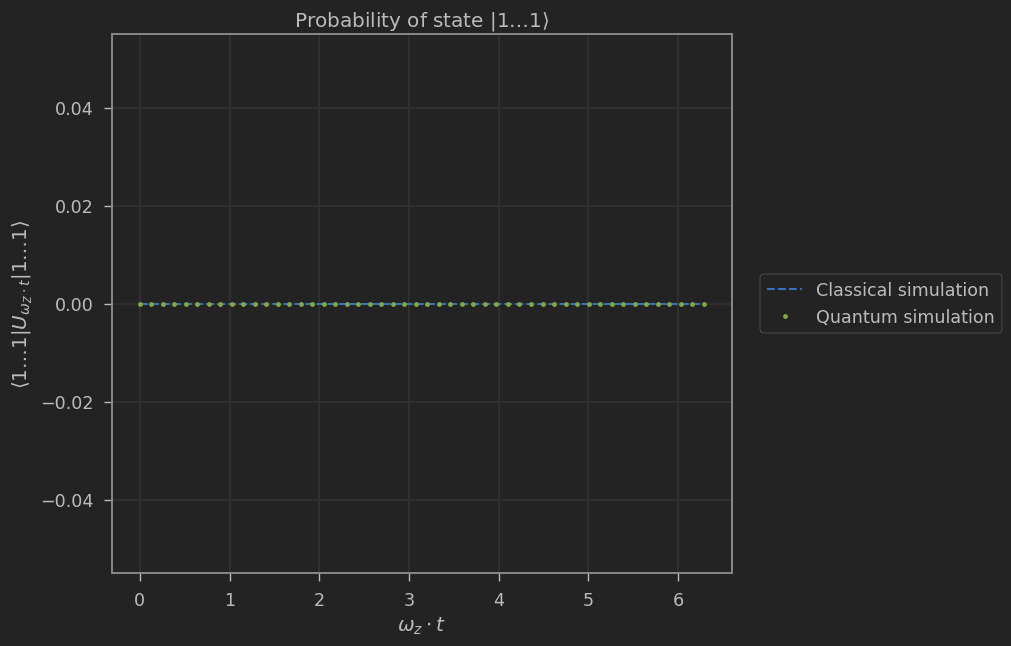

In [22]:
plot(times, probabilities, '--', label = "Classical simulation")
plot(quantum_times, device_probabilities, '.', label = "Quantum simulation")
xlabel(r'$\omega_z \cdot t$')
ylabel(r'$\langle 1\dots 1|U_{\omega_Z\cdot t}|1\dots1\rangle$')
title(r'Probability of state $|1\dots1\rangle$')
legend(loc = 'center right', bbox_to_anchor = (1.45, 0.5))
show()

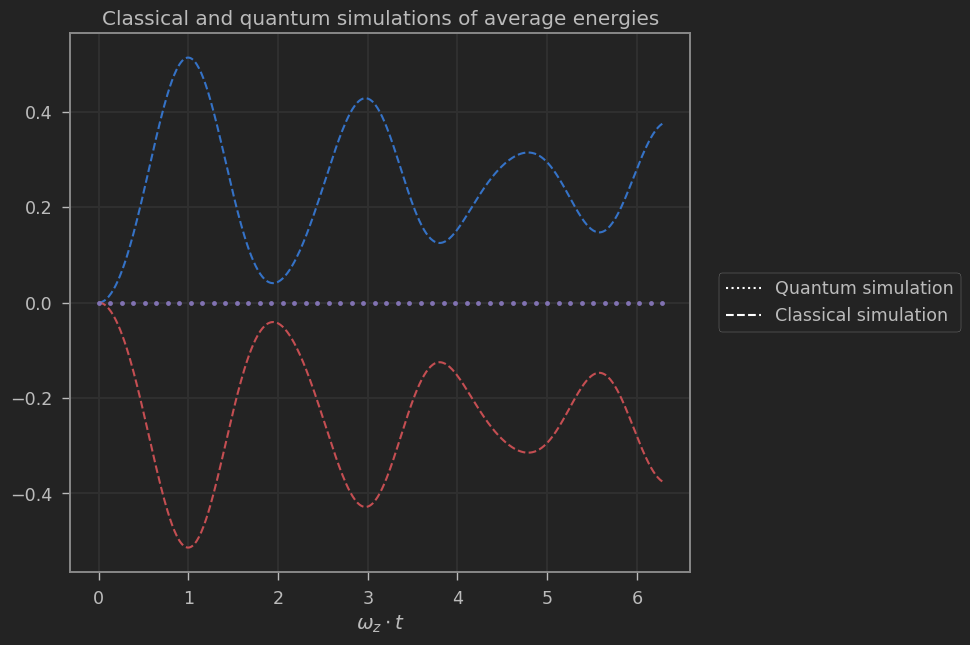

In [23]:
compare_energies(times, quantum_times, internal, device_internal, \
                 interaction, device_interaction)